# Skript that combine all raw MEM and NIOM recordings in one dataframe and perform Butterworth filtration

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import lfilter, butter
import os, glob

import warnings
warnings.filterwarnings("ignore")

In [2]:
"""
Uploading data and renaming columns
Parameters: 
-----------
path: string
    path to the folder with dataframes 

Returns: 
-------
data_list
    List with pd.DataFrames 
"""

def upload_data(path):

    data_list = []
    files_list = os.path.join(path, '*.csv')
    for filename in glob.glob(files_list):
        data = pd.read_csv(filename, header=0)
        data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
        data.rename(columns=lambda x: x.replace('_O', '_opt'), inplace=True)
        data.rename(columns=lambda x: x.replace('.', '_opt_'), inplace=True)
        data.rename(columns=lambda x: x.replace('Bsk', filename + '_Bsk'), inplace=True)
        data.rename(columns=lambda x: x.replace(path, ''), inplace=True)
        data.rename(columns=lambda x: x.replace('.csv_annot.csv', ''), inplace=True)
        data.rename(columns=lambda x: x.replace('\\', ''), inplace=True)
        print(filename, data.shape)
        data_list.append(data)
    return(data_list)
path = r'C:\Users\ecath\Desktop\Research\Raw Data\LD dataset'
data_list = upload_data(path)

C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\1.csv_annot.csv (10173, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\10_Epi.csv_annot.csv (8191, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\11_Endo.csv_annot.csv (10173, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\12_Epi.csv_annot.csv (10173, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\15_Endo.csv_annot.csv (8191, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\16_Epi.csv_annot.csv (8191, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\17_Endo.csv_annot.csv (10173, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\18_Epi.csv_annot.csv (10173, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\22.csv_annot.csv (16667, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\23.csv_annot.csv (16383, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\24.csv_annot.csv (18311, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\25.csv_annot.csv (1

In [3]:
"""
Splitting spreadspeet to the classes by label 

Parameters: 
-----------
data_list: list
    List with pd.DataFrames

Returns: 
-------
drivers, nondrivers, noises: list, list, list
    Lists with pd.DataFrames, one for each of three classes respectively
"""

def class_splitting(data_list):
    
    drivers = []
    nondrivers = []
    noises = []

    for df in data_list:
        driver = pd.DataFrame()
        nondriver = pd.DataFrame()
        noise = pd.DataFrame()
        for col in df.columns[1::3]:
            curr_index = list(df.columns).index(col)
            prev_index = curr_index - 1
            next_index = curr_index + 1
            prev_col = df.iloc[:,prev_index]
            next_col = df.iloc[:,next_index]
            if df[col][0] == 1:
                driver[df.columns[prev_index]] = prev_col
                driver[df.columns[next_index]] = next_col
            elif df[col][0] == 0:
                nondriver[df.columns[prev_index]] = prev_col
                nondriver[df.columns[next_index]] = next_col
            else:
                noise[df.columns[prev_index]] = prev_col
                noise[df.columns[next_index]] = next_col
        drivers.append(driver)
        nondrivers.append(nondriver)
        noises.append(noise)
        
    return(drivers, nondrivers, noises)

drivers, nondrivers, noises = class_splitting(data_list)

In [4]:
"""
Function performs bandpass filter for the digital signal 

Parameters: 
-----------
data: array_like
    An N-dimensional input array
lowcut: float
    Low cutoff frequency
highcut: float
    High cutoff frequency
fs: float
    Sampling rate of the signal
order: int
    The order of the filter.

Returns: 
-------
filtered_signal: array
    The output of the digital filter
"""

def butter_bandpass(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    
    high = highcut / nyq
    low = lowcut / nyq
    
    b, a = butter(order, [low, high], btype='bandpass', analog=False)
    filtered_signal = lfilter(b, a, data)
    
    return filtered_signal

In [6]:
# join all drivers dataframes in one and filtering of the raw MEM and NIOM signals

dr = pd.DataFrame()
for i in range(len(drivers)):
    dr = pd.concat([dr, drivers[i]], axis=1)

mem = dr.iloc[:, ::2]
niom = dr.iloc[:, 1::2]
dr_filtered = pd.DataFrame()

for col in mem.columns:
        dr_filtered[col] = butter_bandpass(mem[col], 5, 20, 1017.25, order=5)
for col in niom.columns:
        dr_filtered[col] = butter_bandpass(niom[col], 5, 20, 1000, order=5)
    

In [7]:
# join all nondrivers dataframes in one and filtering of the raw MEM and NIOM signals


nondr = pd.DataFrame()
for i in range(len(nondrivers)):
    nondr = pd.concat([nondr, nondrivers[i]], axis=1)

mem = nondr.iloc[:, ::2]
niom = nondr.iloc[:, 1::2]
nondr_filtered = pd.DataFrame()

for col in mem.columns:
        nondr_filtered[col] = butter_bandpass(mem[col], 5, 20, 1017.25, order=5)
for col in niom.columns:
        nondr_filtered[col] = butter_bandpass(niom[col], 5, 20, 1000, order=5)
    

In [8]:
# join all noise dataframes in one and filtering of the raw MEM and NIOM signals


ns = pd.DataFrame()
for i in range(len(noises)):
    ns = pd.concat([ns, noises[i]], axis=1)

mem = ns.iloc[:, ::2]
niom = ns.iloc[:, 1::2]
ns_filtered = pd.DataFrame()

for col in mem.columns:
        ns_filtered[col] = butter_bandpass(mem[col], 5, 20, 1017.25, order=5)
for col in niom.columns:
        ns_filtered[col] = butter_bandpass(niom[col], 5, 20, 1000, order=5)
    

In [9]:
#join drivers nondrivers and noise dataframe in one (filtered and nonfiltered)

out = pd.concat([dr, nondr, ns], axis=1)
out_filtered = pd.concat([dr_filtered, nondr_filtered, ns_filtered], axis=1)

In [10]:
path = r'C:\Users\ecath\Desktop\Research\Raw Data'

out.to_csv(path + '\Raw signals.csv', sep=',', header=True)
out_filtered.to_csv(path + '\Raw signals filtered.csv', sep=',', header=True)

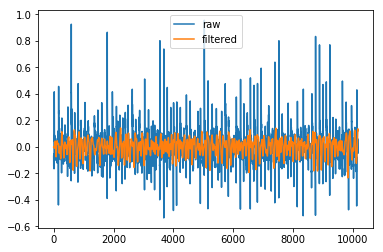

In [24]:
plt.plot(out.iloc[:,:1], label='raw')
plt.plot(out_filtered.iloc[:,:1], label='filtered')
plt.legend()

----------------------------------